# Expanding on Ito et al. (2017) to recover simulated task activity using connectivity matrix


Set up environment

In [1]:
from collections import OrderedDict
import copy
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.set_style("white")
import scipy.stats as stats
import statsmodels.api as sm

/Users/zenkavi/.pyenv/versions/3.8.0/envs/workbase/lib/python3.8/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Import custom modules

In [2]:
sys.path.append('../')
sys.path.append('../../utils/')

# Primary module with most model functions
import model

Helper functions

In [3]:
phi = lambda x: np.tanh(x)

inv_phi = lambda x: np.arctanh(x)

def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)


## Neural network model

In this notebook we expand on simulations described in [Ito et al. (2017)](https://www.nature.com/articles/s41467-017-01000-w.pdf). Ito et al. propose a dynamic neural network model to simulate resting state and task data. Accordingly change in activity in each node is a function of the local connectivity determined by $s$, global connectivity determined by $g$ and task activity for that node described in $I$

\begin{equation*}
\frac{dx_i}{dt}\tau_i = -x_i(t) + s\phi\big(x_i(t)\big) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big)\Bigg) + I_i(t)
\end{equation*}

where transformation function $\phi$ is
\begin{equation*}
\phi(x) = \tanh(x) = \frac{\sinh(x)}{\cosh(x)} = \frac{e^{2x}-1}{e^{2x}+1}
\end{equation*}

This transformation is intended to introduce *"a nonlinearity to the interactions among units that is
similar to aggregate nonlinearity from neuronal action potentials"* as explained in [Cole et al. (2016)](https://www.nature.com/articles/nn.4406.pdf). The effect of this transformation can be seen below in the attenuated signal of the transformed timeseries.

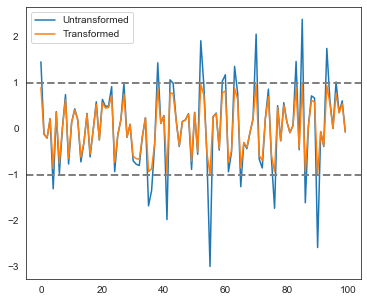

In [4]:
plt.rcParams["figure.figsize"][0] = 6
plt.rcParams["figure.figsize"][1] = 5
a = np.random.normal(size=100)
pa = phi(a)
plt.plot(a, label="Untransformed")
plt.plot(pa, label="Transformed")
plt.axhline(y=1,linewidth=2, color='gray', ls = "--")
plt.axhline(y=-1,linewidth=2, color='gray', ls = "--")
plt.legend()

In Ito et al. (2017) $\tau_i$, $s$, $g$ and $dt$ are set to 1. This simplifies the equation to:

\begin{equation*}
x_i(t) + \frac{dx_i}{dt} = \phi\big(x_i(t)\big) + \sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big) + I_i(t)
\end{equation*}

Note in the synaptic connectivity weight matrix:

`W[..., x]` : column x of matrix denotes all outgoing connection weights from node x  
`W[x, ...]` : row x of matrix denotes all incoming connection weights to node x

`taskdata` is an $n$ by $t$ matrix containing the timeseries for each node where $n$-rows are for nodes and $t$ columns are for the time points.

It is generated by updating each column (each time point) for **all nodes**  

At each time point the differential equation describing the change in activity is solved using the [Runge-Kutta second order method](https://lpsa.swarthmore.edu/NumInt/NumIntSecond.html). Runge-Kutta methods are used to discretize the problem of updating values for continuous time when solving differential equations. Ito et al. hypothesize the differential equation determining the amount of change in each timestep as:

\begin{equation*}
\frac{dx_i}{dt} = \frac{-x_i(t) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big)\Bigg) + s\phi\big(x_i(t)\big) + I_i(t)}{\tau_i}
\end{equation*}

Thus `taskdata` for all nodes $x_i$ consists of the current activity plus a weighted sum of approximate changes in activity calculated using the differential equation.

\begin{equation*}
x_{i}(t+dt) = x_{i}(t) + \frac{k1_{i}+k2_{i}}{2}
\end{equation*}

The first derivative based on $t(0)$ that is used for the approximation is

\begin{equation*}
k1_{i} = \frac{-x_{i}(t) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)}{\tau}
\end{equation*}

$\hat{I}_{i}(t)$ is the spontaneous activity that is the sum of randomly generated noise and task-related stimulation ($\hat{I}_{i}(t) = {I}_{i}(t)+\epsilon(t)$). Since the column-vector of task-related stimulation activity is very sparse ($|I_{i}(t)| \neq 0$ only for $i$ that is the third of the hub nodes and only for a short window of timepoints $t$) **most of the activity feeds into updating the activity of a node is noise (which in this framework is the equivalent of rest activity)**.

Using this slope the first intermediate approximation at the endpoint is

\begin{equation*}
x_{i}^*(t+dt) = x_{i}(t) + k1_{i} dt
\end{equation*}

and the second order approximation for the change in activity is

\begin{equation*}
k2_{i} = \frac{-x_{i}^*(t+dt) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + s\phi\big(x_{i}^*(t+dt)\big) + \hat{I}_{i}(t+1)}{\tau}
\end{equation*}

If we discretize and work through the algebra the row-wise (node-centric) 'expanded' GLM for the column-wise (timepoint-centric) generated data using the Runge-Kutte method would be:

\begin{equation*}
x_{i}(t+1) = x_{i}(t) + dt\frac{k1_{i}+k2_{i}}{2}
\end{equation*}

\begin{equation*}
x_{i}(t+1) = x_{i}(t) + dt\frac{\frac{-x_{i}(t) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)}{\tau}+\frac{-x_{i}^*(t+dt) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + s\phi\big(x_{i}^*(t+dt)\big) + \hat{I}_{i}(t+1)}{\tau}}{2}
\end{equation*}

Replacing $x_{i}^*(t+dt)$

\begin{equation*}
x_{i}(t+1) = x_{i}(t) + dt\frac{\frac{-x_{i}(t) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)}{\tau}+\frac{-x_{i}(t) - k1_{i} dt + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + s\phi\big(x_{i}(t) + k1_{i} dt\big) + \hat{I}_{i}(t+1)}{\tau}}{2}
\end{equation*}

To write out a general equation for $x_i(t+1)$ first we replace the $k1_i$ in the equation. Since $k1_i$ appears always in the context of $x_i(t)+k1_idt$ we plug in the formula for $k1_i$ into this expression and simplify

\begin{equation*}
x_{i}(t) + k1_{i}dt = x_{i}(t)+dt\frac{-x_{i}(t) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)}{\tau}
\end{equation*}

\begin{equation*}
x_{i}(t) + k1_{i}dt = \frac{\tau-dt}{\tau}x_{i}(t)+\frac{dt}{\tau}\Bigg[g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)\Bigg]
\end{equation*}


Then we use this expression in the formula of $x_{i}(t+1)$ 

\begin{equation*}
x_{i}(t+1) = x_{i}(t) + \frac{dt}{2\tau}\Bigg[-x_{i}(t) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t) - \big(x_{i}(t) + k1_{i} dt\big) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + s\phi\big(x_{i}(t) + k1_{i} dt\big) + \hat{I}_{i}(t+1)\Bigg]
\end{equation*}

Plugging in $x_{i}(t) + k1_{i}dt$

\begin{equation*}
x_{i}(t+1) = x_{i}(t) + \frac{dt}{2\tau}\Bigg[-x_{i}(t) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t) - \big(\frac{\tau-dt}{\tau}x_{i}(t)+\frac{dt}{\tau}\Bigg[g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)\Bigg]\big) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + s\phi\big(\frac{\tau-dt}{\tau}x_{i}(t)+\frac{dt}{\tau}\Bigg[g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)\Bigg]\big) + \hat{I}_{i}(t+1)\Bigg]
\end{equation*}

Simplifying common terms

\begin{equation*}
x_{i}(t+1) = x_{i}(t) + \frac{dt}{2\tau}\Bigg[\frac{dt-2\tau}{\tau}x_{i}(t) + \frac{\tau-dt}{\tau}\Bigg[g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)\Bigg] + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + s\phi\big(\frac{\tau-dt}{\tau}x_{i}(t)+\frac{dt}{\tau}\Bigg[g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)\Bigg]\big) + \hat{I}_{i}(t+1)\Bigg]
\end{equation*}

Extracting $x_{i}(t)$ outside the rest of the expression

\begin{equation*}
x_{i}(t+1) = \frac{2\tau^2+dt(dt-2\tau)}{2\tau^2}x_{i}(t) + \frac{dt}{2\tau}\Bigg[\frac{\tau-dt}{\tau}\Bigg(g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)\Bigg) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + s\phi\big(\frac{\tau-dt}{\tau}x_{i}(t)+\frac{dt}{\tau}\Bigg(g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)\Bigg)\big) + \hat{I}_{i}(t+1)\Bigg]
\end{equation*}

This is a pretty messy expression. In words it describes the activity in the next time point for a node as a function of:
- current node activity 
- current activity depending on connectivity with other nodes, local connectivity and task stimulation 
- activity in the next time step depending on connectivity with other nodes, first order approximation in the current node and task stimulation  
all of which are weigted by different constants that depends on the time steps

We can use this equation to expand the traditinal GLM. A traditional GLM would have modeled

\begin{equation*}
x_{i}(t) = h(t) \circledast I(t)
\end{equation*}

that is the activity of a voxel at a given time point would have been a function of the convolved task activity for that node at that time point plus some noise (For these simulations we ignore other movement confounds etc. included in level 1 models in real data).  

Note: Extending the GLM in this way is intended to account for the connectivity between nodes and how **task** activity in the previous step affects task activity in the current step for a given node. Is the same thing as 'subtracting out' resting state to look at the remaining task activity?


## Helper functions

### cGLM function

In [5]:
def run_ucr_glm(all_nodes_ts, task_reg):
    nregions = all_nodes_ts.shape[0]
    ucr_task_betas = np.zeros((nregions))
    ucr_mods = []
    
    for region in range(0, nregions):
        cur_y = all_nodes_ts[region,:]
        ucr_mod = sm.OLS(cur_y, task_reg)
        ucr_res = ucr_mod.fit()
        ucr_task_betas[region] = ucr_res.params[0]
        ucr_mods.append(ucr_mod)
    
    return ({"ucr_task_betas":ucr_task_betas,
            "ucr_mods": ucr_mods})

### eGLM function

In [6]:
def run_ext_glm(all_nodes_ts, task_reg, weight_matrix, dt, tau, g, s): 
    
    nregions = all_nodes_ts.shape[0]
    ext_task_betas = np.zeros((nregions))
    ext_mods = []
    
    for region in range(0, nregions):
        cur_y = all_nodes_ts[region,:]
        incoming_connections = weight_matrix[region, :]
        incoming_connections = np.delete(incoming_connections,region)
        drop_region = [region]
        
        #DV
        next_y = cur_y[1:] #shift column up to predict activity in next time point

        #IV 1
        cur_y = cur_y[:-1] #drop last time point
        cur_y = ((2*(tau**2)+dt*(dt-2*tau))/(2*(tau**2)))*cur_y
        
        #IV 2
        other_ns_cur_spont = np.delete(all_nodes_ts, drop_region, axis=0)[:,:-1] #dropping last col/timepoint
        other_ns_cur_spont = other_ns_cur_spont.T
        other_ns_cur_spont = np.apply_along_axis(phi, 0, other_ns_cur_spont)
        other_ns_cur_spont = np.sum(other_ns_cur_spont*incoming_connections, axis = 1) 
        other_ns_cur_spont = (dt/(2*tau))*((tau-dt)/tau)*g*other_ns_cur_spont
        
        #IV 3
        cur_y_phi = all_nodes_ts[region,:]
        cur_y_phi = cur_y_phi[:-1]
        cur_y_phi = (dt/(2*tau))*((tau-dt)/tau)*s*phi(cur_y_phi)
        
        #IV 4
        cur_n_task = (dt/(2*tau))*((tau-dt)/tau)*task_reg[:-1]
        
        #IV 5
        other_ns_next_spont = np.delete(all_nodes_ts, drop_region, axis=0)[:,1:] #dropping first col/timepoint
        other_ns_next_spont = other_ns_next_spont.T
        other_ns_next_spont = np.apply_along_axis(phi, 0, other_ns_next_spont)
        other_ns_next_spont = np.sum(other_ns_next_spont*incoming_connections, axis = 1)
        other_ns_next_spont = (dt/(2*tau))*g*other_ns_next_spont
        
        #IV 6
        cur_n_first_appr = all_nodes_ts[region,:]
        cur_n_first_appr = cur_n_first_appr[:-1]
        cur_n_first_appr = ((tau-dt)/tau)*cur_n_first_appr
        tmp = np.delete(all_nodes_ts, drop_region, axis=0)[:,:-1] #dropping last col/timepoint
        tmp = tmp.T
        tmp = np.apply_along_axis(phi, 0, tmp)
        tmp = np.sum(tmp*incoming_connections, axis = 1) 
        tmp = (dt/tau)*g*tmp
        cur_n_first_appr = cur_n_first_appr+tmp
        tmp = all_nodes_ts[region,:]
        tmp = tmp[:-1]
        tmp = s*phi(tmp)
        cur_n_first_appr = cur_n_first_appr+tmp
        cur_n_first_appr = cur_n_first_appr+task_reg[:-1]
        cur_n_first_appr = (dt/(2*tau))*s*phi(cur_n_first_appr)
        
        #IV 7
        cur_n_next_task = (dt/(2*tau))*task_reg[1:]
        
        #All IVs in design matrix
        ext_des_mat = np.concatenate((cur_y.reshape(-1,1), other_ns_cur_spont.reshape(-1,1)), 1)
        ext_des_mat = np.concatenate((ext_des_mat, cur_y_phi.reshape(-1,1)), 1)
        ext_des_mat = np.concatenate((ext_des_mat, cur_n_task.reshape(-1,1)), 1)
        ext_des_mat = np.concatenate((ext_des_mat, other_ns_next_spont.reshape(-1,1)), 1)
        ext_des_mat = np.concatenate((ext_des_mat, cur_n_first_appr.reshape(-1,1)), 1)
        ext_des_mat = np.concatenate((ext_des_mat, cur_n_next_task.reshape(-1,1)), 1)

        ext_mod = sm.OLS(next_y, ext_des_mat)
        ext_res = ext_mod.fit()
        ext_params = ext_res.params

        ext_task_betas[region] = ext_params[6]
        ext_mods.append(ext_mod)
    
    return ({"ext_task_betas": ext_task_betas,
            "ext_mods": ext_mods})



### Stimulus timing

In [7]:
def make_stimtimes(Tmax, dt, stim_nodes, stim_mag, tasktiming=None, ncommunities = 3,nodespercommunity = 35):
    totalnodes = nodespercommunity*ncommunities
    T = np.arange(0,Tmax,dt)
    # Construct timing array for convolution 
    # This timing is irrespective of the task being performed
    # Tasks are only determined by which nodes are stimulated
    if tasktiming is None:
        tasktiming = np.zeros((1,len(T)))
        for t in range(len(T)):
            if t%2000>500 and t%2000<1000:
                tasktiming[0,t] = 1.0
    stimtimes = np.zeros((totalnodes,len(T)))
    
    # When task is ON the activity for a stim_node at that time point changes the size of stim_mag
    for t in range(len(T)):
        if tasktiming[0,t] == 1:
            stimtimes[stim_nodes,t] = stim_mag
            
    return(stimtimes)

### Baseline calculation

In [13]:
flatten = lambda l: [item for sublist in l for item in sublist]

def get_true_baseline(ts, stim_nodes = np.array(range(11)), nonstim_nodes = np.array(range(11, 105)), stim_mag = 0.5):
    stim_t = []
    nonstim_t = []
    
    for t in range(len(ts[0])):
        if t%2000>500 and t%2000<1000:
            stim_t.append(ts[stim_nodes,t])
        else:
            nonstim_t.append(ts[nonstim_nodes, t])
            
    stim_t = flatten(stim_t)
    nonstim_t = flatten(nonstim_t)
     
    stim_baseline = np.mean(stim_t)
    nonstim_baseline = np.mean(nonstim_t)
        
    #stim_baseline =  sm.OLS(stim_t, np.repeat(stim_mag, len(stim_t))).fit().params[0]
    #nonstim_baseline = sm.OLS(nonstim_t, np.repeat(0, len(nonstim_t))).fit().params[0]
    
    return(stim_baseline, nonstim_baseline)

### Simulation wrapper

In [9]:
def sim_network_task_glm(ncommunities = 3, 
                         innetwork_dsity = .60, 
                         outnetwork_dsity = .08, 
                         hubnetwork_dsity = .25, 
                         nodespercommunity = 35, 
                         plot_network = False,
                         dt = 1, tau = 1, g = 1, s = 1, 
                         topdown = True, bottomup = False, 
                         local_com = 1, 
                         Tmax = 100000, 
                         plot_task = False, 
                         stimsize = np.floor(35/3.0), 
                         tasktiming = None, 
                         noise = None,
                         noise_loc = 0, 
                         noise_scale = 0,
                         stim_mag = .5,
                         plot_glm = True):

    totalnodes = nodespercommunity*ncommunities

    # Construct structural matrix
    S = model.generateStructuralNetwork(ncommunities=ncommunities,
                                        innetwork_dsity=innetwork_dsity,
                                        outnetwork_dsity=outnetwork_dsity,
                                        hubnetwork_dsity=hubnetwork_dsity,
                                        nodespercommunity=nodespercommunity,
                                        showplot=plot_network)
    # Construct synaptic matrix
    W = model.generateSynapticNetwork(S, showplot=plot_network)

    if plot_network:
        plt.rcParams["figure.figsize"][0] = 5
        plt.rcParams["figure.figsize"][1] = 4
        sns.heatmap(W, xticklabels=False, yticklabels=False)
        plt.xlabel('Regions')
        plt.ylabel('Regions')
        plt.title("Synaptic Weight Matrix -- Coupling Matrix")

    T = np.arange(0,Tmax,dt)

    # Construct timing array for convolution 
    # This timing is irrespective of the task being performed
    # Tasks are only determined by which nodes are stimulated
    if tasktiming is None:
        tasktiming = np.zeros((1,len(T)))
        for t in range(len(T)):
            if t%2000>500 and t%2000<1000:
                tasktiming[0,t] = 1.0

    if plot_task:
        if len(T)>9999:
            plt.plot(T[:10000], tasktiming[0,:10000])
            plt.ylim(top = 1.2, bottom = -0.1)
        else:
            plt.plot(T, tasktiming[0,:])
            plt.ylim(top = 1.2, bottom = -0.1)

    stimtimes = np.zeros((totalnodes,len(T)))

    # Construct a community affiliation vector
    Ci = np.repeat(np.arange(ncommunities),nodespercommunity) 
    # Identify the regions associated with the hub network (hub network is by default the 0th network)
    hub_ind = np.where(Ci==0)[0] 

    if topdown:
        stim_nodes_td = np.arange(0, stimsize,dtype=int)
    else:
        stim_nodes_td = None
    
    if bottomup:
        # Identify indices for one of the local communities
        local_ind = np.where(Ci==local_com)[0] 
        # Identify efferent connections from local network to hub network
        W_mask = np.zeros((W.shape))
        W_mask[local_ind,hub_ind] = 1.0
        local2hub_connects = np.multiply(W,W_mask)
        local_regions_wcon = np.where(local2hub_connects!=0)[0]
        local_regions_ncon = np.setdiff1d(local_ind,local_regions_wcon)
        #If there are enough nodes in the local community with hub connections:
        if len(local_regions_wcon)>= np.floor(stimsize/2):
            #Half of the stimulated local community nodes have hub connections while the other does not
            stim_nodes_bu = np.hstack((np.random.choice(local_regions_ncon, int(np.floor(stimsize/2)), replace=False),
                                np.random.choice(local_regions_wcon, int(stimsize-np.floor(stimsize/2)), replace=False)))
        else:
            stim_nodes_bu = np.hstack((np.random.choice(local_regions_wcon, len(local_regions_wcon), replace=False),
                                np.random.choice(local_regions_ncon, int(stimsize-len(local_regions_wcon)), replace=False)))
    else:
        stim_nodes_bu = None
    
    if stim_nodes_td is not None and stim_nodes_bu is not None:
        stim_nodes = np.hstack((stim_nodes_td, stim_nodes_bu))
    elif stim_nodes_td is not None and stim_nodes_bu is None:
        stim_nodes = stim_nodes_td
    else:
        stim_nodes = stim_nodes_bu
    
    # When task is ON the activity for a stim_node at that time point changes the size of stim_mag
    for t in range(len(T)):
        if tasktiming[0,t] == 1:
            stimtimes[stim_nodes,t] = stim_mag

    #Make task data
    out = model.networkModel(W,Tmax=Tmax,dt=dt,g=g,s=s,tau=tau, I=stimtimes, noise=noise, noise_loc = noise_loc, noise_scale = noise_scale)
    taskdata = out[0]
    
    #Use only a subset of data for GLM's if it's too long
    if taskdata.shape[1]>44999:
        short_lim = int(np.floor(taskdata.shape[1]/3))
        y = copy.copy(taskdata[:,:short_lim])
        I = copy.copy(stimtimes[:,:short_lim])
    else:
        y = copy.copy(taskdata)
        I = copy.copy(stimtimes)

    # Run uncorrected and extended GLM to compare task regressor
    ucr_model = run_ucr_glm(all_nodes_ts = y, task_reg = I[stim_nodes[0],:])
    ext_model = run_ext_glm(all_nodes_ts = y, task_reg = I[stim_nodes[0],:], 
                          weight_matrix = W, dt = dt, tau = tau, g = g, s = s)
    
    ucr_betas = ucr_model["ucr_task_betas"]
    ext_betas = ext_model["ext_task_betas"]
    
    ucr_glms = ucr_model["ucr_mods"]
    ext_glms = ext_model["ext_mods"]
        
    return({"W":W, "ucr_betas": ucr_betas, "ucr_glms": ucr_glms, "ext_betas": ext_betas, "ext_glms": ext_glms,
            "stim_nodes": stim_nodes, "taskdata": taskdata})



### GLM plotter

In [10]:
def plot_sim_network_glm(data,
                         width = 8,
                        height = 6,
                        ncoms = 3,
                        nnods = 35,
                        task_type = "td",
                        ucr_label = "cGLM (baseline)",
                        ext_label = "eGLM (baseline)",
                         base_label = None,
                        alp = 1):
    
    totalnodes = ncoms*nnods
    
    plt.rcParams["figure.figsize"][0] = width
    plt.rcParams["figure.figsize"][1] = height
    
    plt.plot(data['ucr_betas'], alpha = alp, color = "C0", label = ucr_label)
    plt.plot(data['ext_betas'], alpha = alp, color = "C1", label = ext_label)
    
    stim_baseline, nonstim_baseline = get_true_baseline(data['taskdata'])
    

    all_nodes = list(range(totalnodes))
    stim_ind = [1 if x in data['stim_nodes'] else 0 for x in all_nodes]
    baseline_vec = [stim_baseline if x == 1 else nonstim_baseline for x in stim_ind]
    plt.plot(baseline_vec, 
     color = "black", linestyle = '--', label = base_label, alpha = alp)
    
    plt.ylabel('Beta',fontsize=14)
    plt.xlabel('Node',fontsize=14)
    
    for n in range(1,ncoms):
        plt.axvline(x=nnods*n,linewidth=2, color='gray', ls = "--")
    
    plt.legend(loc="best")


## Baseline simulation

First we simulate a topdown task that stimulates nodes only in the hub network. No noise is added to this simulation. It is intended to serve as a baseline to compare the changes for all the tests below. 

The x-axis denoted each node and the y-axis the regression coefficient between the task activity and each nodes' time series. The blue line the parameters using the classic GLM framework (cGLM) and the yellow line are the parameter estimates when the time series is corrected for its connectivity with the rest of the network using the extended GLM equation above (eGLM). The vertical lines denote community boundaries. In the baseline simulation there is one hub network and two local networks. The horizontal line depicts the expected magnitude of the task parameter accounting for that nodes connectivity and stimulation status (detailed below).

In [11]:
base_sim = sim_network_task_glm(noise=None)

Text(85, 3.5, 'Local 2')

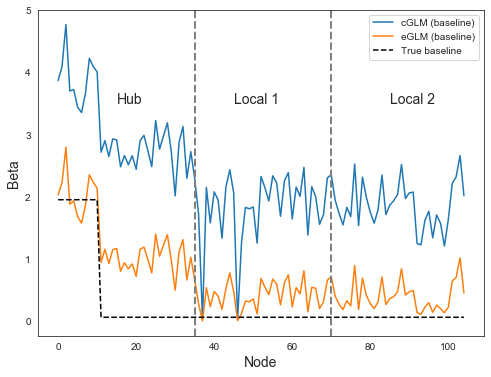

In [14]:
plot_sim_network_glm(data = base_sim, base_label = "True baseline")
plt.text(x = 15, y = 3.5, s = "Hub", fontsize = 14)
plt.text(x = 45, y = 3.5, s = "Local 1", fontsize = 14)
plt.text(x = 85, y = 3.5, s = "Local 2", fontsize = 14)

With the change in the GLM equation the task parameter estimates can get change in two ways:

- bias [higher mean]: the correlation between the timeseries and task regressor is stronger for a given node
- variance [more variable estimates]: the correlation between the timeseries and the task regressor varies more across nodes. Since the task regressor is the same for all nodes (since we wouldn't empirically know which nodes are stimulated by it) this increased variability would have to be due to increased variability in the timeseries across nodes. 

## Different noise levels

In [ ]:
td_stimtimes_0_5 = make_stimtimes(Tmax=10000, dt=1, stim_nodes=base_sim['stim_nodes'], stim_mag=0.5)

In [ ]:
noise_ts = {}

noise_sds = [0, .5, 1, 2, 5]

for noise_sd in noise_sds:
    var_name = "noise_"+str(noise_sd)
    noise_ts[var_name] = model.networkModel(base_sim['W'],Tmax=10000,dt=1,g=1,s=1,tau=1, I=td_stimtimes_0_5, noise=1, noise_scale = noise_sd)[0]

First we examine the effect of different amounts of noise. When the noise parameter is turned on a random number from a normal distribution with a mean of 0 and specified standard deviation is added to the activity level at each time point. The amount of noise is changed by modifying the variance of this distribution and leaving the mean at 0. Changing the amount of noise added to each time point we look at  
- the timeseries of a stimulated and non-stimulated node  
- the effect of eGLM parameter estimates  
- the relationship between task timing and activity levels  
- the effect of eGLM on time series of nonstimulated nodes  

The time series for data generated without noise points out the amplification of the task signal through connections to the rest of the network. This is why the activity for a non-stimulated node (right plot) is not at 0 for the whole task either. Importantly, this suggests that the "correct" baseline that the task activity parameter estimates should be compared to is not the stimulus timing for each node but the amplified activity based on the rest of the network.

In [ ]:
plt.rcParams["figure.figsize"][0] = 18
plt.rcParams["figure.figsize"][1] = 6

#Plot same stimulated node's timeseries with and without noise
fig,a =  plt.subplots(1,2)
curns = [0, 21]
rkeys = list(noise_ts.keys())
rkeys.reverse()
for i in range(2):
    curn = curns[i]
    for j in rkeys:
        if j == 'noise_0':
            a[i].plot(range(noise_ts[j].shape[1]), noise_ts[j][curn,:], linewidth = 6,label=j)
        else:
            a[i].plot(range(noise_ts[j].shape[1]), noise_ts[j][curn,:],label=j)
    a[i].plot(range(noise_ts[j].shape[1]), td_stimtimes_0_5[0], label="Task", color="black")
    a[i].legend(loc="best")
    a[i].set_ylim([-8,8])
    
a[0].set_title("Stimulated node")
a[1].set_title("Non-stimulated node")

In [ ]:
ucr_glms = {}
ext_glms = {}

for k in noise_ts.keys():
    ucr_glms[k] = run_ucr_glm(all_nodes_ts = noise_ts[k], task_reg = td_stimtimes_0_5[0])
    ext_glms[k] = run_ext_glm(all_nodes_ts = noise_ts[k], task_reg = td_stimtimes_0_5[0], weight_matrix = base_sim['W'], dt = 1, tau = 1, g = 1, s = 1)

To calculate the 'correct' baseline for timeseries that are generated through stimulations both directly from the task as well as the rest of the network we average the magnitude of the signal for timepoints where the task was "on" and when the task was "off" separately.

The effect of adding noise to the timeseries has different effects on the task parameter estimates using the two approaches.  

For the classic GLM:
- without noise the overestimation for all nodes is the worst
- with noise the correct baselines get closer to 0 for stimulated nodes because the mean of the noise distribution is 0. When the SD of the noise distribution is higher when this mean is kept constant then the magnitude of noise added to each time point is larger to keep the average at 0. This leads for the change in activity in each time point to be driven more by noise and less by signal thereby bringing the baseline closer to the mean noise.
- with more noise the estimates get closer to their lower true baselines as well, though the overestimation remains a problem throughout.

For the extended GLM
- without noise the parameter estimates for stimulated nodes are recovered well but the overestimation of the task effect in non-stimulated noides continues to be a problem.
- with the addition of noise all nodes are initially overcorrected (though the qualitative difference between stimulated and non-stimulated nodes is preserved) but approach the true baseline with increasing noise.

In [ ]:
values = ["C"+str(x) for x in range(len(noise_ts.keys()))]
col_lookup = dict(zip(rkeys, values))

In [ ]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 6
fig, a =  plt.subplots(1,2)

task_betas = [{k:v['ucr_task_betas'] for k,v in ucr_glms.items()}, {k:v['ext_task_betas'] for k,v in ext_glms.items()}]

for i in range(len(task_betas)):
    for j in rkeys:
        a[i].plot(task_betas[i][j], label = j, color = col_lookup[j])
        stim_baseline, nonstim_baseline = get_true_baseline(noise_ts[j])
        
        a[i].plot(np.concatenate((np.repeat(stim_baseline, 11), np.repeat(nonstim_baseline,94))), 
                  color = col_lookup[j], linestyle = '--')
    
        for n in range(1,3):
            a[i].axvline(x=35*n,linewidth=2, color='gray', ls = "--")
        a[i].legend(loc="best")
        a[i].set_ylim([-1.5,4.5])
        
plt.ylabel('Beta',fontsize=14)
plt.xlabel('Node',fontsize=14)
a[0].set_title("Classic GLM")
a[1].set_title("Extended GLM")

To get a better sense of where the task parameter estimates above are coming from we plot the IV (activity of a node) over the DV (task timing) from the models they derived from. The IV's are colored by the amount of noise added to them. Top row depicts the activity of a stimulated node from the hub community while the bottom row is from a nonstimulated node from a local community. The slopes of the dotted lines are the task parameter estimates denoted as single points in the graphs above. The left column plots the raw activity level using the cGLM parameter estimate for the line slopes while the right column plots the residualized activity after the time series is corrected for the activity of the rest of the network.  

We observe  
- That the timeseries of nodes become more variable with increasing noise levels.  
- The slopes for eGLM are lower for both node types compared to cGLM slopes.  
- The overcorrection of nonstimulated nodes when a little bit of noise is added is depicted as a negative slope.   


In [ ]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 12

noise_levels = ['noise_1', 'noise_0.5', 'noise_0']
plot_nodes = [1, 55]
glm_types = ["ucr", "ext"]

clm_var = glm_types
row_var = plot_nodes
col_var = noise_levels

fig, a = plt.subplots(len(clm_var), len(row_var))

task_x = td_stimtimes_0_5[0][1:]
xvals = np.arange(0,.6,.1)

for i in range(len(row_var)):
    for j in range(len(clm_var)):
        for k in range(len(col_var)):
        
            cur_row = row_var[i]
            cur_clm = clm_var[j]
            cur_col = col_var[k]
            jit = float(cur_col.split("_")[1])/50
            
            if cur_clm == "ucr":
                raw_y = ext_glms[cur_col]['ext_mods'][cur_row].endog
                a[i, j].scatter(task_x+jit, raw_y, label = cur_col, alpha=.5)
                s = ucr_glms[cur_col]['ucr_task_betas'][cur_row]
                y = s*xvals
                a[i, j].plot(xvals, y, '--', color = "C"+str(k))
                a[i, j].set_ylim([-3,4.5])

            if cur_clm == "ext":
                raw_y = ext_glms[cur_col]['ext_mods'][cur_row].endog
                res_x = ext_glms[cur_col]['ext_mods'][cur_row].exog[:,:-1]
                res_mod = sm.OLS(raw_y, res_x).fit()
                res_y = res_mod.resid
                a[i, j].scatter(task_x+jit, res_y, label = cur_col, alpha=.5)
                s = ext_glms[cur_col]['ext_task_betas'][cur_row]
                y = s*xvals
                a[i, j].plot(xvals, y, '--', color = "C"+str(k))
                a[i,j].set_ylim([-3,4.5])

            
            a[i, j].set_title("GLM: "+ str(cur_clm) +", Node: " + str(cur_row))
            a[i, j].legend(loc="lower center")

The reason for the overcorrection of non-stimulated nodes in eGLM with the smallest amount of noise is not immediately apparent. We can understand it better by breaking it down:

What is the "overcorrection"?   
- Negative slope for the dotted line above for non-stimulated nodes (second row right graph above); the dip of eGLM parameter estimates below the baseline minimum.  

What is the "negative slope"?
- Lower mean of time points when task is on compared to when it's off    

How is the corrected time series with a little noise different from the corrected timeseries without noise in how it relates to the task regressor? (see below)
- Without noise the corrected time series of a non-stimulated node goes down to the same constant (0) level whenever the task is on. So the relationship between the task regressor and the timeseries is completely removed.
- With a little bit of noise added to each time point, however, the corrected timeseries of a nonstimulated node hovers around the 0-level, always below the task regressor. Thus, the relationship is not completely removed but systematically but instead becomes negative.
- When noise is increase the magnitude of this hovering at each time point is larger, more frequently going above the task regressor. The relationship between the task regressor and the more nosier corrected time series thus returns to 0 on average.


In [ ]:
noise_levels = ['noise_0','noise_0.5','noise_1']
plot_node = 55

fig, a = plt.subplots(3,2)

for i, cur_noise in enumerate(noise_levels):
    start = 450
    end = 1200
    x = range(start, end)
    
    raw_y = ext_glms[cur_noise]['ext_mods'][plot_node].endog
    res_x = ext_glms[cur_noise]['ext_mods'][plot_node].exog[:,:-1]
    res_mod = sm.OLS(raw_y, res_x).fit()
    res_y = res_mod.resid
    
    a[i, 0].plot(x, raw_y[start:end],label="UCR "+cur_noise, color = "C"+str(i))
    a[i, 1].plot(x, res_y[start:end],label="EXT "+cur_noise, color = "C"+str(i))
    a[i, 0].plot(x, td_stimtimes_0_5[0][start:end], color="black")
    a[i, 1].plot(x, td_stimtimes_0_5[0][start:end], color="black")
    a[i, 0].legend(loc="upper right")
    a[i, 1].legend(loc="upper right")
    a[i, 0].set_ylim([-2,2])
    a[i, 1].set_ylim([-2,2])


Functionalize above plot (even if not for the form it is in above then whatever you'd like it to look like for the rest of tests)

## Different network structures

A summary of all changing parameters and their effect on task parameters estimated by both methods can be found in the [Summary](#summary) section.

### Changing network density

#### Increased innetwork density

The innetwork density controls the probability of a given node to be connected to another node within the same community. In a topdown task (where only the hub network is stimulated) increasing the innetwork density exacerbates the bleeding of true activity from the stimulated nodes onto non-stimulated nodes in the same network.

In [ ]:
new_sim = sim_network_task_glm(innetwork_dsity = .85)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (IND = 0.60)", ext_label="eGLM (IND = 0.60)")
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (IND = 0.85)", ext_label="eGLM (IND = 0.85)")

#### Increased outnetwork density

The outnetwork density controls the probability of local networks having outside connections with other local communities. Since this is a topdown task increasing the outnetwork density doesn't have an effect on neither the classic nor eGLM estimates.

In [ ]:
new_sim = sim_network_task_glm(outnetwork_dsity = .25)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (OND = 0.08)", ext_label="eGLM (OND = 0.08)")
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (OND = 0.25)", ext_label="eGLM (OND = 0.25)")

#### Increased hub network density

The hub network density controls the probability of a hub node to be connected to other local networks. Increasing it impacts the classic GLM estimates in the local networks by increasing the leakage from the hub network.

In [ ]:
new_sim = sim_network_task_glm(hubnetwork_dsity = .5)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (HND = 0.25)", ext_label="eGLM (HND = 0.25)")
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (HND = 0.50)", ext_label="eGLM (HND = 0.50)")

### Changing information transfer strength (ITS)

The information transfer strength control the degree to which activity incoming from a connected node affects the change in the activity of a given node. One parameter ($g$) controls the degree of change for activity coming from the rest of the network to the node while another ($s$) control the weight of current node's activity for the next time step.

#### Increasing $g$ 
Increasing global connectivity increases the impact of any stimulated node on all other nodes. By making all time series more similar to each other this amplifies the effect of a stimulated node on all other nodes and increases the multicollinearity. As a result both the bias and variance of the task estimates increase.

In [ ]:
new_sim_g5 = sim_network_task_glm(g = 5)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (g = 1)", ext_label="eGLM (g = 1)")
plot_sim_network_glm(data = new_sim_g5, ucr_label="cGLM (g = 5)", ext_label="eGLM (g = 5)")

#### Decreasing $g$

Expectedly both the bias and the variance of the estimates decrease when each node is affected less by other nodes especially by stimulated ones.

In [ ]:
new_sim_g0 = sim_network_task_glm(g = 0)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (g = 1)", ext_label="eGLM (g = 1)")
plot_sim_network_glm(data = new_sim_g0, ucr_label="cGLM (g = .5)", ext_label="eGLM (g = .5)")

To visualize multicollinearity we plot the time series of three types of nodes, a stimulated node, a non-stimulated node in the hub community and a non-stimulated node in a local community with respect to task timing. The distance between the stimulated node and the other nodes decreases with increasing global ITS.

In [ ]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 6

#stim node, non-stim hub node, non-stim local node
plot_nodes = [1, 21, 51]
x_len = td_stimtimes_0_5.shape[1]

sims = [new_sim_g05, base_sim, new_sim_g5]
titles = ['g = 0.5', 'g = 1', 'g = 5']
fig, a = plt.subplots(1,3)

for cur_node in plot_nodes:
    for i, cur_sim in enumerate(sims):
        a[i].plot(range(x_len), cur_sim['taskdata'][cur_node][:x_len], label = "Node: "+str(cur_node))
        a[i].plot(range(x_len), td_stimtimes_0_5[0], '--', color = "black")
        a[i].legend(loc = "center right")
        a[i].set_title(titles[i])
        a[i].set_ylim([0, 4.5])


#### Increasing $s$

Increasing local ITS  increases the autocorrelation within the timeseries of a given node (the effect of current time step on the next).

Change in variance: The time series of all nodes are also more similar to each other.
Why?

Change in bias: If the $s$ is high you multiply the node's current activity by a large number before adding it to the total change of activity for that node. Without noise the initial value of a node's activity is just a random number from a uniform distribution between 0-1. This is transformed before multiplying with $s$ so even if this random number is large at $t=0$ it decreases for the next time step eventually diminishing to 0. Then since there isn't any noise the change is driven only by the task activity. So $s$ multiplies the transformed task activity from the previous timestep for the node. The larger it is the larger the change.  

How about the change in variance?  
Looks like variance decreases both when you increase and decrease $s$
Decrease in variance of task parameters should mean that the timeseires of all nodes are becoming more similar to each other
Why should the increased influence of a given node's previous time point make all nodes more like each other?
Looking carefully it seems the decrease in variance is more of a thing for non-stim nodes/particularly local community nodes

If s is very large all nodes are similarly very large
because activity in each time point include some degree activity of all nodes in the rest of network the effect of local processing governed by s can't be independent of the rest of the networks activity levels

If s is small then the change in activity is affected less by the previous time point activity and more by the task activity. Without noise task activity for non-stim local community nodes is 0
But what's plotted here is how that relates to the same/true task regressor/timing
If you have a bunch of timeseries that are affected more by a vector of 0's then how they relate to a non-0 vector of task timing will be more similar too?

In [ ]:
new_sim_s0_g0 = sim_network_task_glm(s = 0, g = 0)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (s,g = 1)", ext_label="eGLM (s,g = 1)")
plot_sim_network_glm(data = new_sim_s0_g0, ucr_label="cGLM (s,g = 0)", ext_label="eGLM (s,g = 0)")

In [ ]:
new_sim_s5 = sim_network_task_glm(s = 5)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (s = 1)", ext_label="eGLM (s = 1)")
plot_sim_network_glm(data = new_sim_s5, ucr_label="cGLM (s = 5)", ext_label="eGLM (s = 5)")

#### Decreasing $s$

In [ ]:
new_sim_s0 = sim_network_task_glm(s = 0)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (s = 1)", ext_label="eGLM (s = 1)")
plot_sim_network_glm(data = new_sim_s0, ucr_label="cGLM (s = .5)", ext_label="eGLM (s = .5)")

In [ ]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 6

#stim node, non-stim hub node, non-stim local node
plot_nodes = [1, 21, 51]
x_len = td_stimtimes_0_5.shape[1]

sims = [new_sim_s05, base_sim, new_sim_s5]
titles = ['s = 0.5', 's = 1', 's = 5']
fig, a = plt.subplots(1,3)

for cur_node in plot_nodes:    
    for i, cur_sim in enumerate(sims):
        a[i].plot(range(x_len), cur_sim['taskdata'][cur_node][:x_len], label = "Node: "+str(cur_node))
        a[i].plot(range(x_len), td_stimtimes_0_5[0], '--', color = "black")
        a[i].legend(loc = "center right")
        a[i].set_title(titles[i])
        a[i].set_ylim([0, 6])

In [ ]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 6

#stim node, non-stim hub node, non-stim local node
plot_nodes = [1, 21, 51]
x_len = td_stimtimes_0_5.shape[1]

sims = [new_sim_s0_g0,new_sim_s01, new_sim_s05, base_sim, new_sim_s5]
titles = ['s, g = 0','s = 0.1' ,'s = 0.5', 's = 1', 's = 5']
fig, a = plt.subplots(1,3)

for i,cur_sim in enumerate(sims):    
    for j,cur_node in enumerate(plot_nodes):
        a[j].plot(range(x_len), cur_sim['taskdata'][cur_node][:x_len], label = str(titles[i]))
        #a[j].plot(range(x_len), td_stimtimes_0_5[0], '--', color = "black")
        a[j].legend(loc = "center right")
        a[j].set_title("Node: " +str(cur_node))
        #a[j].set_ylim([0, 6])

In [ ]:
get_true_baseline(new_sim_s0_g0['taskdata'])

### Changing number of local communities

Does not lead to any difference for either method.

In [ ]:
new_sim = sim_network_task_glm(ncommunities=4)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label=r"cGLM (ncoms = 3)", ext_label="eGLM (ncoms = 3)", ncoms = 4, width = 10)
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (ncoms = 4)", ext_label="eGLM (ncoms = 4)", ncoms = 4, width = 10)

### Changing temporal resolution

Decrease in $dt$ leads to some improvement of classical GLM estimates of stimulated nodes, while increasing it results in noisier estimates for all nodes.

Change in either direction leads to noisier eGLM estimates.


#### Increasing $dt$

In [ ]:
new_sim = sim_network_task_glm(dt=2)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (dt = 1)", ext_label="eGLM (dt = 1)")
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (dt = 2)", ext_label="eGLM (dt = 2)")

#### Decreasing $dt$

In [ ]:
new_sim = sim_network_task_glm(dt = .5)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (dt = 1)", ext_label="eGLM (dt = 1)")
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (dt = .5)", ext_label="eGLM (dt = .5)")

## Different task structures

The initial task was a top down task that stimulated nodes only in the hub network and trickled activity down to the other nodes.

Other task activations are possible.

Things to modulate:  
- Number of nodes stimulated
- Stimulating only local community
- Stimulating both hub and local community
- Magnitude of stimulation (different from 0.5)

### Changing number of stimulated nodes

Makes the overestimation of non-stimulated node estimates in cGLM and their underestimation in the eGLM slightly worse.

In [ ]:
new_sim = sim_network_task_glm(stimsize = np.floor(35/2))

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (stim_size=11)", ext_label="eGLM (stim_size=11)")
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (stim_size=17)", ext_label="eGLM (stim_size=17)")

### Stimulating only local community

The new method seems to work expectedly with a bottom-up task that only stimulates a local community. The overestimated task parameters in the stimulated community are greatly improvement by the eGLM though non-stimulated nodes in the same community are again underestimated. 

**DOUBLE CHECK LOCAL NODES WITH CONNECTIONS ARE EXTRACTED CORRECTLY**

Due to its connections to the stimulated local community there is some leakage to the hub community in the cGLM estimates but again is corrected by eGLM.

The second local community's activity is only minimally impacted by the stimulated local community (since any trickling down would come from the hub network). Expectedly both methods do a reasonable job in estimating this lack of stimulation.

In [ ]:
new_sim = sim_network_task_glm(topdown = False, bottomup=True)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (TD)", ext_label="eGLM (TD)")
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (BU)", ext_label="eGLM (BU)")

### Stimulating both hub and local community



In [ ]:
new_sim = sim_network_task_glm(topdown = True, bottomup=True)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (TD)", ext_label="eGLM (TD)")
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (TD+BU)", ext_label="eGLM (TD+BU)")

### Changing magnitude of stimulation

In [ ]:
new_sim = sim_network_task_glm(stim_mag = .8)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (stim_mag=0.5)", ext_label="eGLM (stim_mag=0.5)")
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (stim_mag=0.8)", ext_label="eGLM (stim_mag=0.8)")

<a id='summary'></a>
## Summary

| Parameters                   | Increase | Decrease |      |
|------------------------------|----------|----------|------|
| Innetwork density            | -        | +        | cGLM |
|                              | o        | o        | eGLM |
| Outnetwork density           | o        | o        | cGLM |
|                              | o        | o        | eGLM |
| Hubnetwork density           | -        | +        | cGLM |
|                              | o        | o        | eGLM |
| g                            | -        | +        | cGLM |
|                              | -        | +        | eGLM |
| s                            | -        | +        | cGLM |
|                              | -        | +        | eGLM |
| tau                          | -        | +        | cGLM |
|                              | -        | -        | eGLM |
| N local community            | o        | o        | cGLM |
|                              | o        | o        | eGLM |
| dt                           | +        | -        | cGLM |
|                              | -        | -        | eGLM |
| N stim nodes                 | -        | +        | cGLM |
|                              | -        | +        | eGLM |
| bottom up task               |          |          | cGLM |
|                              |          |          | eGLM |
| top down and  bottom up task | -        |          | cGLM |
|                              | -        |          | eGLM |
| Magnitude of  stimulation    | o        |          | cGLM |
|                              | -        |          | eGLM |